In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "MYB"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
r = min(5000/len(dataset_), 1)
_, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
#dataset = dataset_
dataset.head()

,id,sequence,length,class
19757,Tp6g37110,METLHPLVLSHVPTSDHRFVVQEMMQSSSWTQEENKKFERALAIYA...,273,1
15428,Pp3c5_7650V3.4.p,MQGSMTHKDISGMFTNAAPSPSGPLSPRAGSALSPGGPYTVDIRMQ...,1349,1
30157,LPERR06G21800.1,MSHHDGSKPYQPRRRPERPPPPPPPPDDAAHSGPSVDDLAAAAAAS...,358,0
8588,Gorai.010G149300.1,MGRALCGDKNGLKKGPWTPEEDKKLIDYIQKHGYGNWRTLPKNAGL...,307,1
32768,Niben101Scf04437g04001.1,MEYSSDTKATVISTSPPSSRSVSPPSSSSCSPNSPPPPPMVVVSPC...,212,0


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1571,0.025586,0.002132,0.008529,0.002132,0.002132,0.046908,0.006397,0.000000,0.000000,0.004264,...,0.0,0.002132,0.0,0.002132,0.004264,0.002132,0.004264,0.000000,0.0,0.0
4399,0.008403,0.004202,0.000000,0.000000,0.000000,0.012605,0.008403,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.004202,0.0,0.0
2899,0.018868,0.000000,0.006289,0.006289,0.000000,0.000000,0.006289,0.000000,0.006289,0.006289,...,0.0,0.000000,0.0,0.006289,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4565,0.014354,0.000000,0.000000,0.014354,0.000000,0.009569,0.004785,0.004785,0.009569,0.004785,...,0.0,0.000000,0.0,0.004785,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2971,0.002439,0.000000,0.000000,0.004878,0.000000,0.002439,0.000000,0.002439,0.002439,0.009756,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.004878,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 440)
X_test: (1000, 440)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,161 (610.00 KB)

 Trainable params: 156,161 (610.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 28s 579ms/step - accuracy: 0.5312 - loss: 0.6929

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6055 - loss: 0.6874   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6533 - loss: 0.6711 - val_accuracy: 0.9325 - val_loss: 0.3534


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.3482

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9349 - loss: 0.2665 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9366 - loss: 0.2489 - val_accuracy: 0.9575 - val_loss: 0.1321


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0483

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9664 - loss: 0.1104 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1158 - val_accuracy: 0.9688 - val_loss: 0.1128


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.1037

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9730 - loss: 0.0925 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.0936 - val_accuracy: 0.9675 - val_loss: 0.1108


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0268

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0686

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9793 - loss: 0.0710 - val_accuracy: 0.9737 - val_loss: 0.1002


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.1975

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.0954 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9759 - loss: 0.0868 - val_accuracy: 0.9650 - val_loss: 0.1081


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0308

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0483

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0523 - val_accuracy: 0.9675 - val_loss: 0.1001


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0249

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0467 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0497 - val_accuracy: 0.9750 - val_loss: 0.0928


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0113

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0302 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0346 - val_accuracy: 0.9575 - val_loss: 0.1477


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0284

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9781 - loss: 0.0791

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.0721 - val_accuracy: 0.9750 - val_loss: 0.0867


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0308

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0404 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0389 - val_accuracy: 0.9750 - val_loss: 0.0881


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0081

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0319

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0294 - val_accuracy: 0.9712 - val_loss: 0.0903


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0229

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0240 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0240 - val_accuracy: 0.9650 - val_loss: 0.1145


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0070

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0289 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0269 - val_accuracy: 0.9675 - val_loss: 0.1166


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0282

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0282 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0235 - val_accuracy: 0.9762 - val_loss: 0.1003


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0062

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0143

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0198 - val_accuracy: 0.9700 - val_loss: 0.1088


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0156

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0180 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0165 - val_accuracy: 0.9787 - val_loss: 0.1019


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0039

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0130

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0179 - val_accuracy: 0.9737 - val_loss: 0.1028


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0013

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0218

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0267 - val_accuracy: 0.9725 - val_loss: 0.1008


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0020

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0082 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0088 - val_accuracy: 0.9700 - val_loss: 0.1219


Epoch 21/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0012

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0150 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0150 - val_accuracy: 0.9775 - val_loss: 0.1102


Epoch 22/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 4.8029e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0047    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0044 - val_accuracy: 0.9737 - val_loss: 0.1129


Epoch 23/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0011

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0016 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9712 - val_loss: 0.1209


Epoch 24/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0010

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0011 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9663 - val_loss: 0.1506


Epoch 25/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0462

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0101 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0083 - val_accuracy: 0.9688 - val_loss: 0.1473


Epoch 26/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0024

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0101 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0094 - val_accuracy: 0.9750 - val_loss: 0.1253


Epoch 27/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 9.2186e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0023    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9688 - val_loss: 0.1454



[Train Accuracy: 99.94% - Test Accuracy: 97.40%]


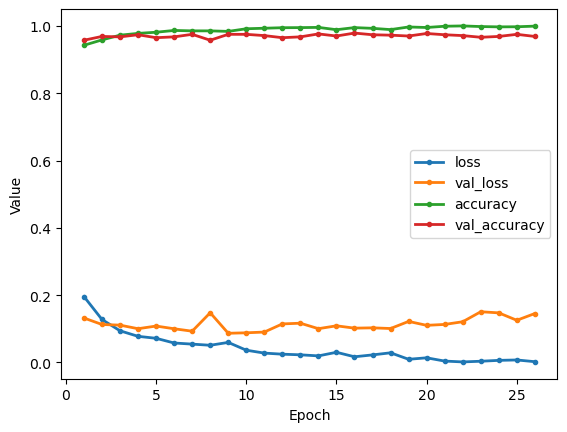

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1571,0.004274,0.0,0.0,0.000000,0.0,0.010684,0.002137,0.0,0.0,0.002137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4399,0.000000,0.0,0.0,0.000000,0.0,0.004219,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2899,0.000000,0.0,0.0,0.006329,0.0,0.000000,0.000000,0.0,0.0,0.006329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4565,0.000000,0.0,0.0,0.009615,0.0,0.004808,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2971,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8662)
X_test: (1000, 8662)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,217,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,993 (8.63 MB)

 Trainable params: 2,260,993 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 29s 601ms/step - accuracy: 0.5000 - loss: 0.6932

 7/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5301 - loss: 0.6930   

14/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5189 - loss: 0.6929

21/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5202 - loss: 0.6925

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5389 - loss: 0.6915

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5658 - loss: 0.6892

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5923 - loss: 0.6846

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6106 - loss: 0.6791 - val_accuracy: 0.9463 - val_loss: 0.3536


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9531 - loss: 0.3412

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9481 - loss: 0.3068 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9534 - loss: 0.2714

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9568 - loss: 0.2443

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9592 - loss: 0.2238

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9612 - loss: 0.2081

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9628 - loss: 0.1956

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9632 - loss: 0.1929 - val_accuracy: 0.9725 - val_loss: 0.0958


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.0904

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9924 - loss: 0.0435 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9916 - loss: 0.0413

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9918 - loss: 0.0397

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9917 - loss: 0.0388

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9917 - loss: 0.0379

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9916 - loss: 0.0376

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9915 - loss: 0.0377 - val_accuracy: 0.9762 - val_loss: 0.0889


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.0895

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9876 - loss: 0.0577 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9900 - loss: 0.0448

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9918 - loss: 0.0378

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9929 - loss: 0.0334

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9935 - loss: 0.0310

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9940 - loss: 0.0294

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9942 - loss: 0.0288 - val_accuracy: 0.9787 - val_loss: 0.0914


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9844 - loss: 0.0198

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9934 - loss: 0.0235 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9954 - loss: 0.0199

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0171

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9970 - loss: 0.0153

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9973 - loss: 0.0141

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0131

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9976 - loss: 0.0129 - val_accuracy: 0.9800 - val_loss: 0.0953


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0094

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0204 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0177

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0152

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0135

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0122

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0112

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0109 - val_accuracy: 0.9812 - val_loss: 0.0977


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0025

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0047

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0056

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0059

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0059

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0058

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0058 - val_accuracy: 0.9800 - val_loss: 0.1034


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.1371e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014     

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0019

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0022

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0023

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 0.9787 - val_loss: 0.1030


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0018

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0021 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0049

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0051

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0048

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0045

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0043

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0042 - val_accuracy: 0.9775 - val_loss: 0.1056


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.7493e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7399e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8953e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0011    

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0015

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0016

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0016

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9787 - val_loss: 0.1086


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.9962e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5583e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5981e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6766e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7246e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1160e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 7.5803e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 8.0262e-04 - val_accuracy: 0.9775 - val_loss: 0.1111


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.4062e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9944e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5717e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6745e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0000e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9822e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 8.3980e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 8.6362e-04 - val_accuracy: 0.9787 - val_loss: 0.1200


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.2240e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8608e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7039e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7343e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9428e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0292e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1855e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2295e-04 - val_accuracy: 0.9812 - val_loss: 0.1222


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0017

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4906e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1085e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4310e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9413e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5976e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3378e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2801e-04 - val_accuracy: 0.9812 - val_loss: 0.1229


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.2767e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1235e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4056e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5908e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6188e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6693e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6844e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6837e-04 - val_accuracy: 0.9800 - val_loss: 0.1272


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.7984e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8858e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9320e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8148e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6988e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6054e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5347e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5194e-04 - val_accuracy: 0.9800 - val_loss: 0.1363



[Train Accuracy: 100.00% - Test Accuracy: 98.20%]


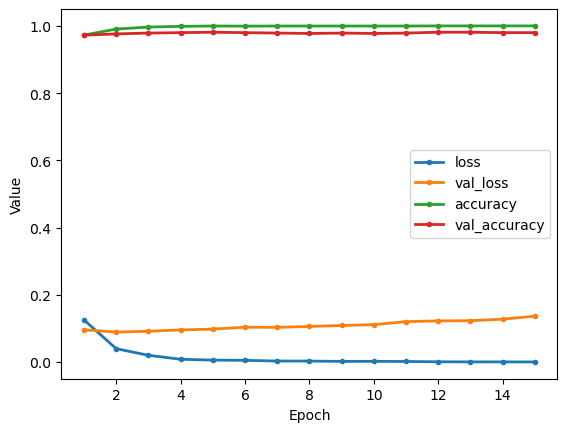

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      37,141,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,182,977 (141.84 MB)

 Trainable params: 37,182,977 (141.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 40s 834ms/step - accuracy: 0.4688 - loss: 0.6932

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.4727 - loss: 0.6932 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.4800 - loss: 0.6931

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.4870 - loss: 0.6931

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.4927 - loss: 0.6930

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.4987 - loss: 0.6929

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.5033 - loss: 0.6928

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5076 - loss: 0.6926

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.5090 - loss: 0.6926

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5094 - loss: 0.6926

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.5098 - loss: 0.6926

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5102 - loss: 0.6926

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5100 - loss: 0.6925

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5094 - loss: 0.6925

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5088 - loss: 0.6925

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5082 - loss: 0.6925

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5084 - loss: 0.6924

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5093 - loss: 0.6923

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5106 - loss: 0.6922

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5120 - loss: 0.6922

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5133 - loss: 0.6921

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5146 - loss: 0.6920

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5162 - loss: 0.6918

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5183 - loss: 0.6917

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5207 - loss: 0.6916

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5235 - loss: 0.6914

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5266 - loss: 0.6912

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5300 - loss: 0.6911

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5335 - loss: 0.6908

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5371 - loss: 0.6906

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5409 - loss: 0.6904

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5447 - loss: 0.6901

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5485 - loss: 0.6898

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5524 - loss: 0.6895

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5562 - loss: 0.6891

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5600 - loss: 0.6888

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5637 - loss: 0.6884

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5674 - loss: 0.6880

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.5711 - loss: 0.6875

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.5747 - loss: 0.6870

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5783 - loss: 0.6865

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5819 - loss: 0.6860

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5854 - loss: 0.6854

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5890 - loss: 0.6849

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5924 - loss: 0.6842

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5959 - loss: 0.6836

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5992 - loss: 0.6829

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6026 - loss: 0.6821

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6059 - loss: 0.6813

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6091 - loss: 0.6805

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.6123 - loss: 0.6797 - val_accuracy: 0.9700 - val_loss: 0.4360


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - accuracy: 0.9688 - loss: 0.4202

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9766 - loss: 0.4174 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9809 - loss: 0.4114

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9818 - loss: 0.4057

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9829 - loss: 0.4005

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9840 - loss: 0.3961

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9850 - loss: 0.3911

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9857 - loss: 0.3868

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9861 - loss: 0.3823

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9863 - loss: 0.3778

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9865 - loss: 0.3729

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9866 - loss: 0.3680

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9867 - loss: 0.3632

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9867 - loss: 0.3586

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9868 - loss: 0.3540

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9868 - loss: 0.3495

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9869 - loss: 0.3450

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9869 - loss: 0.3405

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9869 - loss: 0.3363

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9869 - loss: 0.3322

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9868 - loss: 0.3282

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9867 - loss: 0.3242

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9866 - loss: 0.3203

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9865 - loss: 0.3166

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9863 - loss: 0.3130

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9860 - loss: 0.3098

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9858 - loss: 0.3069

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9856 - loss: 0.3040

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9853 - loss: 0.3011

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9851 - loss: 0.2983

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9849 - loss: 0.2955

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9847 - loss: 0.2928

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9846 - loss: 0.2900

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9845 - loss: 0.2873

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9844 - loss: 0.2847

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9843 - loss: 0.2820

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9842 - loss: 0.2795

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9841 - loss: 0.2769

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9841 - loss: 0.2744

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9840 - loss: 0.2720

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9839 - loss: 0.2696

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9839 - loss: 0.2673

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9838 - loss: 0.2650

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9837 - loss: 0.2627

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9837 - loss: 0.2606

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9836 - loss: 0.2584

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9836 - loss: 0.2563

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9836 - loss: 0.2542

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9836 - loss: 0.2522

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9835 - loss: 0.2502

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9835 - loss: 0.2482 - val_accuracy: 0.9837 - val_loss: 0.0876


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 1.0000 - loss: 0.0199

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0212 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0213

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0214

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0216

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0216

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0216

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9998 - loss: 0.0218

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9996 - loss: 0.0218

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9995 - loss: 0.0216

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9994 - loss: 0.0214

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9993 - loss: 0.0212

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9992 - loss: 0.0211

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9991 - loss: 0.0209

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9990 - loss: 0.0211

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9987 - loss: 0.0215

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9984 - loss: 0.0218

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9982 - loss: 0.0219

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9980 - loss: 0.0220

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9979 - loss: 0.0222

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9977 - loss: 0.0222

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9976 - loss: 0.0222

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9975 - loss: 0.0223

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9973 - loss: 0.0225

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9972 - loss: 0.0226

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9971 - loss: 0.0227

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9969 - loss: 0.0230

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9968 - loss: 0.0233

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9967 - loss: 0.0236

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9966 - loss: 0.0238

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9965 - loss: 0.0240

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9964 - loss: 0.0241

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9964 - loss: 0.0242

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9963 - loss: 0.0243

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9962 - loss: 0.0244

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9962 - loss: 0.0245

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9961 - loss: 0.0245

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9961 - loss: 0.0246

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9960 - loss: 0.0246

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9960 - loss: 0.0246

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9960 - loss: 0.0246

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9959 - loss: 0.0246

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9959 - loss: 0.0246

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9959 - loss: 0.0246

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9959 - loss: 0.0246

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9958 - loss: 0.0246

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9958 - loss: 0.0246

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9958 - loss: 0.0246

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9958 - loss: 0.0246

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9958 - loss: 0.0246

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.9957 - loss: 0.0245 - val_accuracy: 0.9862 - val_loss: 0.0677


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 1.0000 - loss: 0.0047

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.9961 - loss: 0.0447 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9957 - loss: 0.0490

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9958 - loss: 0.0479

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9954 - loss: 0.0496

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9953 - loss: 0.0493

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9953 - loss: 0.0481

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9954 - loss: 0.0467

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9955 - loss: 0.0452

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9955 - loss: 0.0440

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9955 - loss: 0.0427

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9956 - loss: 0.0414

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9956 - loss: 0.0402

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9957 - loss: 0.0391

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9958 - loss: 0.0380

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9959 - loss: 0.0370

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9960 - loss: 0.0361

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9960 - loss: 0.0352

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9961 - loss: 0.0344

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9962 - loss: 0.0337

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9963 - loss: 0.0329

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9963 - loss: 0.0322

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9964 - loss: 0.0316

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9965 - loss: 0.0310

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9965 - loss: 0.0304

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9966 - loss: 0.0298

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9967 - loss: 0.0292

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9967 - loss: 0.0287

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9968 - loss: 0.0282

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9968 - loss: 0.0278

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9969 - loss: 0.0273

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9969 - loss: 0.0269

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9970 - loss: 0.0264

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9970 - loss: 0.0261

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9971 - loss: 0.0257

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9971 - loss: 0.0253

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9971 - loss: 0.0250

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9972 - loss: 0.0246

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9972 - loss: 0.0243

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9972 - loss: 0.0240

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9973 - loss: 0.0237

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9973 - loss: 0.0234

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9973 - loss: 0.0231

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9973 - loss: 0.0228

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9974 - loss: 0.0226

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9974 - loss: 0.0223

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9974 - loss: 0.0221

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9974 - loss: 0.0218

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9975 - loss: 0.0216

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9975 - loss: 0.0214

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9975 - loss: 0.0211 - val_accuracy: 0.9762 - val_loss: 0.0707


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9844 - loss: 0.0190

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9883 - loss: 0.0148

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9905 - loss: 0.0125

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9919 - loss: 0.0110

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9929 - loss: 0.0100

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9936 - loss: 0.0092

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9942 - loss: 0.0086

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9947 - loss: 0.0080

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9951 - loss: 0.0076

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9954 - loss: 0.0072

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9957 - loss: 0.0069

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9960 - loss: 0.0066

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9962 - loss: 0.0063

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9964 - loss: 0.0061

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9965 - loss: 0.0059

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9967 - loss: 0.0057

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9968 - loss: 0.0055

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9970 - loss: 0.0054

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9971 - loss: 0.0052

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9972 - loss: 0.0051

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9973 - loss: 0.0050

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9974 - loss: 0.0049

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9975 - loss: 0.0048

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9975 - loss: 0.0047

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9976 - loss: 0.0046

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9977 - loss: 0.0045

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9977 - loss: 0.0044

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9978 - loss: 0.0044

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9979 - loss: 0.0043

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9979 - loss: 0.0042

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9980 - loss: 0.0041

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9980 - loss: 0.0041

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9980 - loss: 0.0042

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9981 - loss: 0.0043

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9981 - loss: 0.0044

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9981 - loss: 0.0044

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9982 - loss: 0.0045

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9982 - loss: 0.0045

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9982 - loss: 0.0046

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9982 - loss: 0.0046

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9983 - loss: 0.0047

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9983 - loss: 0.0047

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9983 - loss: 0.0047

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9983 - loss: 0.0048

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9984 - loss: 0.0048

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9984 - loss: 0.0048

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9984 - loss: 0.0048

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9984 - loss: 0.0048

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9984 - loss: 0.0048

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9985 - loss: 0.0049

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9985 - loss: 0.0049 - val_accuracy: 0.9812 - val_loss: 0.0696


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 0.0014

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 0.0013

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 0.0012

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0012

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0012

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0011

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 0.0011

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0011

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0011

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0011

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0011

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0011

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0011

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0011

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0011

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0011

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0011

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0011

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0010

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0010

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0010

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0010

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0010

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0010

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0010

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0012

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0013

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0014

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0015

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9999 - loss: 0.0016

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9999 - loss: 0.0017

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9999 - loss: 0.0017

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9999 - loss: 0.0018

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9999 - loss: 0.0019

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9999 - loss: 0.0019

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9999 - loss: 0.0020

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9999 - loss: 0.0020

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9999 - loss: 0.0021

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9999 - loss: 0.0021

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9999 - loss: 0.0022

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9999 - loss: 0.0022

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9999 - loss: 0.0023

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.9825 - val_loss: 0.0697


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 4.8397e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 5.8952e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.0245e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.0930e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.1761e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.2739e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.3711e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.4038e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.4252e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.4261e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9999 - loss: 0.0015    

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 0.0021

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9997 - loss: 0.0026

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9996 - loss: 0.0030

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9996 - loss: 0.0033

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9996 - loss: 0.0035

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9995 - loss: 0.0037

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9995 - loss: 0.0039

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9995 - loss: 0.0040

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9995 - loss: 0.0041

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9995 - loss: 0.0042

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9995 - loss: 0.0042

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9995 - loss: 0.0043

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0043

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0043

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0043

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9994 - loss: 0.0043

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9994 - loss: 0.0043

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9994 - loss: 0.0043

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9994 - loss: 0.0043

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9994 - loss: 0.0043

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9994 - loss: 0.0043

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9995 - loss: 0.0043

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9995 - loss: 0.0043

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9995 - loss: 0.0042

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9995 - loss: 0.0042

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9995 - loss: 0.0042

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9995 - loss: 0.0042

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9995 - loss: 0.0042

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9995 - loss: 0.0041

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9995 - loss: 0.0041

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9995 - loss: 0.0041

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9995 - loss: 0.0041

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9995 - loss: 0.0040

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9995 - loss: 0.0040

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9995 - loss: 0.0040

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9995 - loss: 0.0040

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9995 - loss: 0.0039

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9995 - loss: 0.0039

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9995 - loss: 0.0039

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9995 - loss: 0.0039 - val_accuracy: 0.9850 - val_loss: 0.0697


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 4.5643e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.6128e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.5795e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9990 - loss: 0.0053    

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9986 - loss: 0.0075

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9984 - loss: 0.0085

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9983 - loss: 0.0089

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9983 - loss: 0.0091

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9983 - loss: 0.0091

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9983 - loss: 0.0090

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9983 - loss: 0.0088

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9983 - loss: 0.0087

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9984 - loss: 0.0085

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9984 - loss: 0.0083

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9985 - loss: 0.0082

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9985 - loss: 0.0080

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9985 - loss: 0.0078

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9986 - loss: 0.0076

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9986 - loss: 0.0075

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9986 - loss: 0.0073

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9987 - loss: 0.0072

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9987 - loss: 0.0070

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9987 - loss: 0.0069

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9987 - loss: 0.0068

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9988 - loss: 0.0067

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9988 - loss: 0.0065

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9988 - loss: 0.0064

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9988 - loss: 0.0063

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9989 - loss: 0.0062

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9989 - loss: 0.0061

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9989 - loss: 0.0060

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9989 - loss: 0.0059

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9989 - loss: 0.0058

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9989 - loss: 0.0058

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9990 - loss: 0.0057

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9990 - loss: 0.0056

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9990 - loss: 0.0055

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9990 - loss: 0.0054

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9990 - loss: 0.0054

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9990 - loss: 0.0053

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9991 - loss: 0.0052

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9991 - loss: 0.0052

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9991 - loss: 0.0051

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9991 - loss: 0.0050

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9991 - loss: 0.0050

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9991 - loss: 0.0049

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9991 - loss: 0.0049

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9991 - loss: 0.0048

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9992 - loss: 0.0048

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9992 - loss: 0.0047

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9992 - loss: 0.0047 - val_accuracy: 0.9875 - val_loss: 0.0699


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 3.3669e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.7539e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.0024e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.0418e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.0723e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.0938e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.1029e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.1039e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.1011e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.0815e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0559e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0393e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.0166e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.9912e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.9650e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.9390e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.9156e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.8906e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8645e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8414e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 3.8224e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.8039e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.7832e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.7623e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.7412e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.7194e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.7014e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 3.6843e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 3.6666e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 3.6498e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 3.6320e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 3.6147e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 3.5991e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 3.5836e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.5696e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.5559e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.5421e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.5282e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.5148e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.5024e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.4903e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.4782e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.4665e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.4554e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.4445e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.4342e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.4241e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.4140e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.7738e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.1117e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 4.4364e-04 - val_accuracy: 0.9837 - val_loss: 0.0755


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 1.6711e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.7436e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.6273e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.9000e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.0515e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.1020e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.1992e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.2516e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9998 - loss: 9.7229e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9997 - loss: 0.0014    

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9996 - loss: 0.0018

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9995 - loss: 0.0020

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9994 - loss: 0.0022

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9994 - loss: 0.0023

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9994 - loss: 0.0024

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9994 - loss: 0.0025

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9993 - loss: 0.0026

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9993 - loss: 0.0026

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9993 - loss: 0.0026

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9993 - loss: 0.0027

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9993 - loss: 0.0027

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9993 - loss: 0.0027

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9993 - loss: 0.0027

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9993 - loss: 0.0027

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9993 - loss: 0.0027

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9993 - loss: 0.0027

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9993 - loss: 0.0027

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9993 - loss: 0.0027

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9993 - loss: 0.0026

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9993 - loss: 0.0026

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9993 - loss: 0.0026

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9993 - loss: 0.0026

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9994 - loss: 0.0026

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9994 - loss: 0.0026

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9994 - loss: 0.0026

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9994 - loss: 0.0025

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9994 - loss: 0.0025

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9994 - loss: 0.0025

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9994 - loss: 0.0025

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9994 - loss: 0.0025

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9994 - loss: 0.0025

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9994 - loss: 0.0024

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0024

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0024

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0024

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0024

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0024

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0023

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0023

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0023

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9875 - val_loss: 0.0716


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.9734e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.0627e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.0077e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.0197e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.0332e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.0296e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.0234e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.0245e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.0311e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.0364e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.0445e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.0520e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.0614e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.0685e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.0732e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.0783e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.0822e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.0892e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.0955e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.0994e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1046e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.1094e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.1126e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.1168e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.1193e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.1231e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.1263e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1280e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1297e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1314e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.1345e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1373e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.1401e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.1427e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1453e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1479e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1504e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1520e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.2477e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.3357e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4168e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.4917e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.5611e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 2.6255e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 2.6857e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 2.7415e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 2.7936e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 2.8422e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 2.8872e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 2.9289e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9999 - loss: 2.9690e-04 - val_accuracy: 0.9812 - val_loss: 0.0803


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.4079e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.0113e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.9424e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.0829e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 2.2294e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 2.3753e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.4392e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.4698e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.4999e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.5045e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.4946e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.4860e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.4696e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.4537e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.4372e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.4212e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.4025e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.3851e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.3729e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3621e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3513e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.3433e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.3360e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.3295e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.3219e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.3196e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.3160e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.3111e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.3054e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.2987e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.2926e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.2857e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.2832e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.2804e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.2776e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.2741e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.2703e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.2661e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.2615e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.2573e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.2533e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.2491e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.2445e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.2395e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.2342e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.2286e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.2232e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.2178e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.2123e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.2067e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.2013e-04 - val_accuracy: 0.9850 - val_loss: 0.0775


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.5903e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.5411e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.5611e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.5970e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5969e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.5904e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.5881e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.5782e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.5631e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.5456e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.5294e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.5148e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.5014e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4862e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4719e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4594e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.4489e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4424e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4383e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4356e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4320e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4282e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4238e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4193e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4168e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.4138e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4110e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4086e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4058e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4035e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4010e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3985e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.3959e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.3934e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.3907e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.3881e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.3854e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.3826e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3797e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3841e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3883e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3919e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3952e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3983e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4008e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4027e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4042e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4058e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4072e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4083e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.4094e-04 - val_accuracy: 0.9850 - val_loss: 0.0793


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.1622e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.0793e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3678e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.4584e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.4836e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.4893e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.4763e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.4499e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4220e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3979e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.3754e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3545e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3344e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3185e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3066e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2952e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2842e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2767e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2701e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2636e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2567e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2502e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.2440e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.2384e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.2331e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.2278e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2233e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2192e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2150e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2111e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2075e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2039e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2004e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.1974e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1941e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1908e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1874e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1842e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1808e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1775e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1742e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1709e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.1678e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1647e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1618e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1588e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1561e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1536e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.1509e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.1514e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.1519e-04 - val_accuracy: 0.9850 - val_loss: 0.0814


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 1.0000 - loss: 6.5524e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.8029e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 7.0936e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.0668e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 7.0769e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 7.0257e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 7.2251e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 7.4065e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 7.5485e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 7.6436e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 7.6868e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.7160e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.7259e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.7251e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.7194e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.7103e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.6998e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.7040e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.7041e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.7384e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.8660e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.9769e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 8.0680e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 8.1514e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 8.2350e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 8.3069e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.3682e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.4198e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.4647e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.5023e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.5501e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.5904e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.6254e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.6625e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.6943e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.7237e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.7487e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.7707e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.7886e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.8028e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.8145e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.8254e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.8372e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.8488e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.8577e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.8645e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.8707e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.8759e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.8833e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.9108e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 8.9371e-05 - val_accuracy: 0.9850 - val_loss: 0.0839


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 6.4366e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.4694e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.6337e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.5040e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 7.6320e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.6588e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 7.6919e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.7569e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.7878e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.7854e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.7559e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.6978e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.6844e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.6743e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.6498e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.6214e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.5917e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 7.6062e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.6282e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 7.6485e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.6576e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.6564e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.7009e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.7384e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.7688e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.7907e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.8081e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.8224e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.8310e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.8389e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.8444e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.8449e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.8422e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.8436e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 7.8411e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 7.8354e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.8365e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.8335e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.8292e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.8273e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.8246e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.8205e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.8140e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.8063e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.7981e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.7876e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.7774e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 7.7927e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.8065e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.8188e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 7.8307e-05 - val_accuracy: 0.9850 - val_loss: 0.0851


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 4.6759e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 7.0108e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 7.0742e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 7.6661e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.8215e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.7688e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.7451e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.6532e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.5299e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.4181e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3113e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.2019e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.0971e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.9935e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.8930e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.8130e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.7417e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.6794e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.6211e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.5657e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.5290e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.4957e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.4681e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.4562e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.4414e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.4262e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.4114e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.3979e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.3831e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.3665e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.3495e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3343e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3190e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.3031e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.2876e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.2711e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.2537e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.2411e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.2275e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.2145e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.2019e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1887e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1768e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1658e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1542e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1444e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1345e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1240e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1128e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1008e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 6.0893e-05 - val_accuracy: 0.9850 - val_loss: 0.0862


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 3.2322e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.0802e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.2271e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.2700e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.4823e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.6278e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.7029e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8315e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.1111e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 4.2915e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.6792e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.9648e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.1969e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 5.6416e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.0155e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.3187e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.5570e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.7489e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.9037e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 7.0314e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 7.1329e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 7.2214e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 7.2994e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 7.3601e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 7.4052e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 7.4412e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.4679e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.4898e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.5073e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.5232e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.5350e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.5398e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.5437e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.5537e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.5596e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.5612e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.5601e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.5566e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.5550e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.5524e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.5492e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.5437e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.5392e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.5320e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.5226e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.5226e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.5213e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.5191e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.5154e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.5102e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 7.5052e-05 - val_accuracy: 0.9862 - val_loss: 0.0861



[Train Accuracy: 100.00% - Test Accuracy: 98.30%]


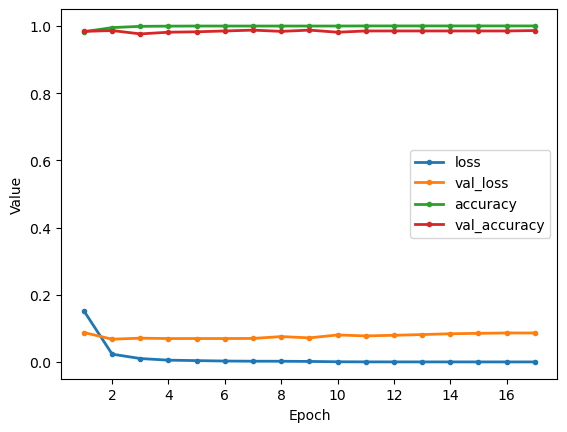

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/MYB/report_G3ZIWR3V.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################